# Test of mosaicking together the 30 Dor fields: A, B, C, & D

In [1]:
from pathlib import Path
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from mpdaf.obj import Image
from astropy.io import fits
from astropy.wcs import WCS
import reproject

sns.set_context("talk")
sns.set_color_codes()

## Define the target WCS for mosaicking the 4 fields together

Use the image from Castro to define the WCS for reprojection.

In [2]:
mosaic_ha_hdulist = fits.open("../data/MUSE_R136toWill/GAUS_Ha6562.8_060_Will.fits")
mosaic_ha_hdulist.info()

Filename: ../data/MUSE_R136toWill/GAUS_Ha6562.8_060_Will.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1158   ()      
  1  DATA          1 ImageHDU        52   (650, 650)   float64   
  2  DATA          1 ImageHDU        52   (650, 650)   float64   
  3  DATA          1 ImageHDU        52   (650, 650)   float64   


In [3]:
mosaic_hdr = mosaic_ha_hdulist[1].header

Note that the header still refers to a 3rd dimension, even though this is just an image.  We need to remove all the keywords that mention dimension 3 so that the reprojection will work.

In [4]:
del mosaic_hdr["*3"]
del mosaic_hdr["CD3_*"]

## Test with the Hβ image.

First we make an HDU of each field for the full mosaic.

In [5]:
pieces = {}
for field in "ABCD":
    infile = f"../data/lmc-30dor-{field}-hi-4861-bin01-sum.fits"
    hdu = fits.open(infile)["DATA"]
    del hdu.header["*3"]
    del hdu.header["CD3_*"]
    newdata, footprint = reproject.reproject_interp(
        hdu,
        mosaic_hdr,
    )
    pieces[field] = newdata

Plot each piece on top of one another:

Text(0.5, 1.0, 'Hβ overlapping pieces')

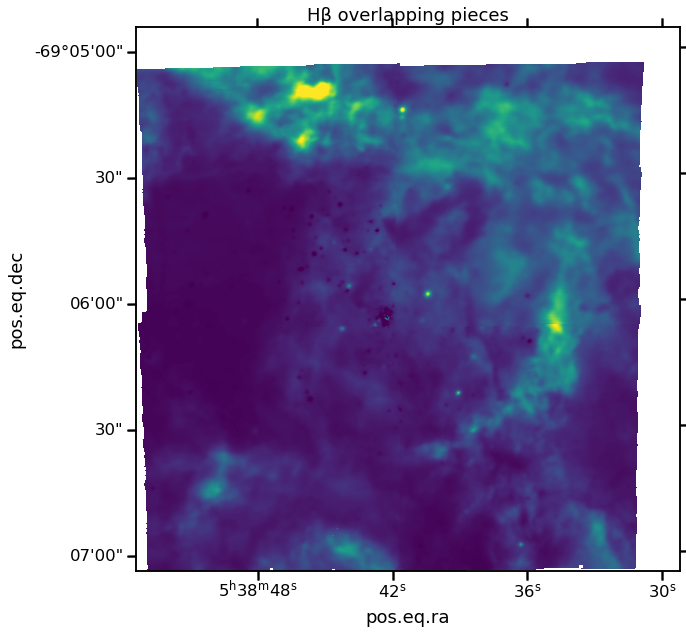

In [6]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw=dict(projection=WCS(mosaic_hdr)),
)
vmax = 5e5
ax.imshow(pieces["A"], vmin=0, vmax=vmax)
ax.imshow(pieces["B"], vmin=0, vmax=vmax)
ax.imshow(pieces["C"], vmin=0, vmax=vmax)
ax.imshow(pieces["D"], vmin=0, vmax=vmax)
ax.set_title("Hβ overlapping pieces")

That looks fine - the edges of the pieces show slight artifacts, but they are not very noticeable.

Now try combining the images with median:

In [7]:
combo = np.nanmedian(
    np.stack(list(pieces.values())),
    axis=0,
)
combo.shape

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


(650, 650)

Text(0.5, 1.0, 'Hβ median mosaic')

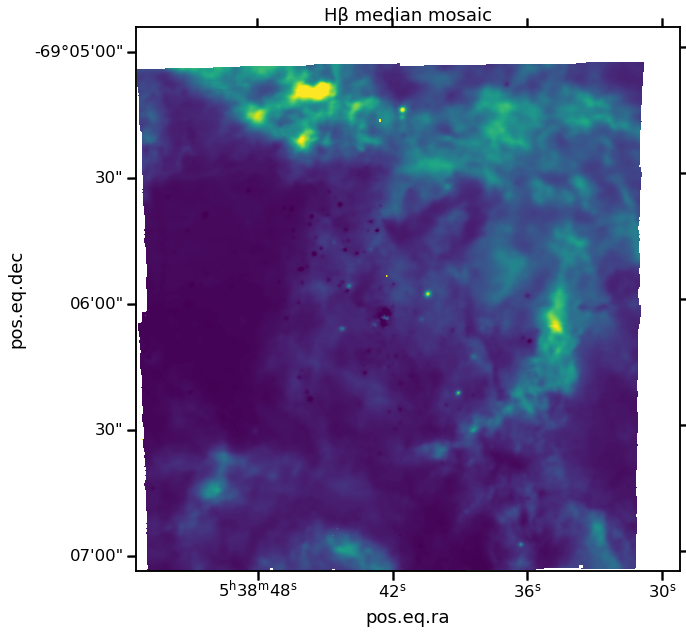

In [8]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw=dict(projection=WCS(mosaic_hdr)),
)
vmax = 5e5
ax.imshow(combo, vmin=0, vmax=vmax)
ax.set_title("Hβ median mosaic")

This time the artifacts are even less visible.

We do seem to cut off a small amount of the lower left field at the bottom.

## Compare with the Hα image from Castro:

Text(0.5, 1.0, 'Hα from Castro')

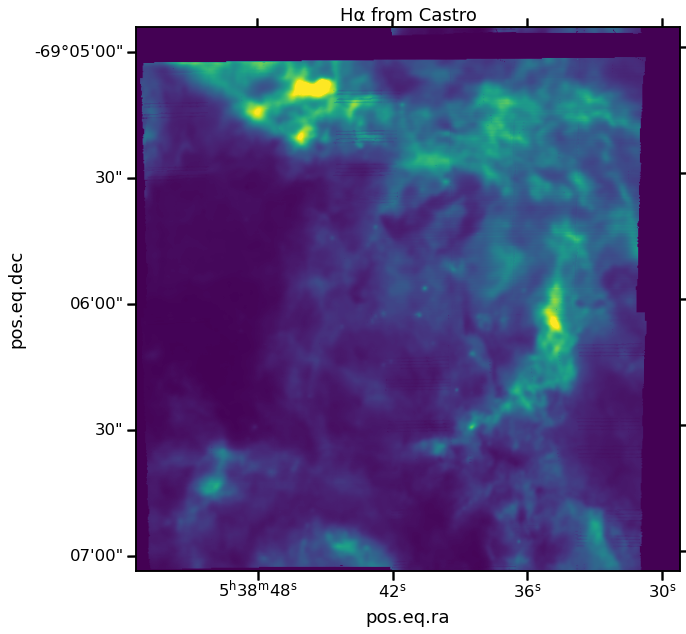

In [9]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw=dict(projection=WCS(mosaic_hdr)),
)
haflux = mosaic_ha_hdulist[1].data * mosaic_ha_hdulist[3].data
ax.imshow(haflux, vmin=0, vmax=10e5)
ax.set_title("Hα from Castro")

Text(0.5, 1.0, 'Hα / Hβ')

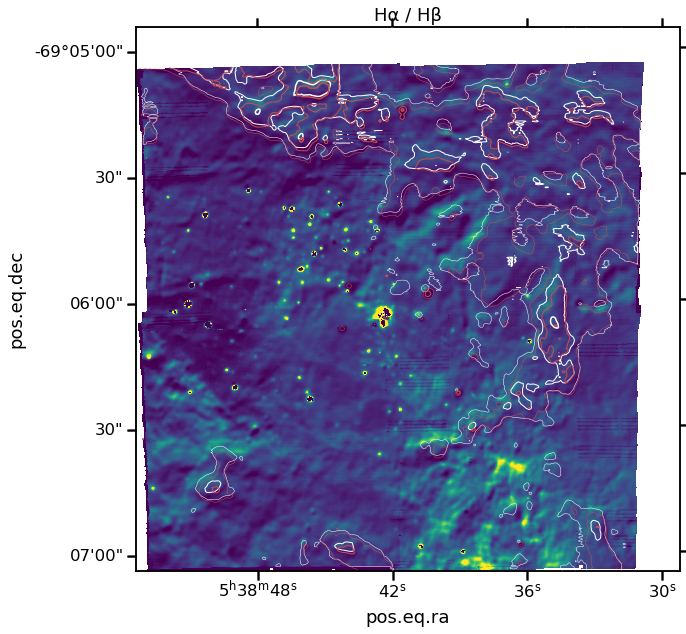

In [10]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw=dict(projection=WCS(mosaic_hdr)),
)
haflux = mosaic_ha_hdulist[1].data * mosaic_ha_hdulist[3].data
decrement = haflux / combo
ax.imshow(decrement, vmin=1.5, vmax=6.0)
ax.contour(
    haflux,
    levels=[2.5e5, 5e5, 10e5],
    linewidths=[0.5, 1.0, 1.5],
    colors="w",
)
ax.contour(2 * combo, levels=[2.5e5, 5e5, 10e5], linewidths=[0.5, 1.0, 1.5], colors="r")
ax.set_title("Hα / Hβ")

It looks like there is an astrometric offset here

The Castro paper says that they based the astrometric calibration on catalog of Selman (1999).

There is a line-emitting star near the center, which we could use to adjust the astrometry.

## Try and fix the astrometry

I looked at the same star on the Castro images and on our images (field A) and got the coordinates from DS9:

In [11]:
from astropy.coordinates import SkyCoord

c_castro = SkyCoord(ra=84.6602735, dec=-69.1035065, unit="deg")
c_eso = SkyCoord(ra=84.6599803, dec=-69.1036748, unit="deg")

Shift_1 = c_castro.ra - c_eso.ra
Shift_2 = c_castro.dec - c_eso.dec
Shift_1.deg, Shift_2.deg

(0.0002932000000015478, 0.00016829999999856682)

It looks like field C has a slightly different shift.  I am using a different star for this:

In [12]:
c_castro_C = SkyCoord(84.6689140, -69.0992165, unit="deg")
c_eso_C = SkyCoord(84.6684931, -69.0995408, unit="deg")

Shift_1C = c_castro_C.ra - c_eso_C.ra
Shift_2C = c_castro_C.dec - c_eso_C.dec
Shift_1C.deg, Shift_2C.deg

(0.00042089999999461725, 0.0003243000000026086)

We need to add these to the `CRVAL` of our images in order to align with Castro:

In [13]:
pieces = []
for field in "ABCD":
    infile = f"../data/lmc-30dor-{field}-hi-4861-bin01-sum.fits"
    hdu = fits.open(infile)["DATA"]
    del hdu.header["*3"]
    del hdu.header["CD3_*"]
    if field == "C":
        hdu.header["CRVAL1"] += Shift_1C.deg
        hdu.header["CRVAL2"] += Shift_2C.deg
    else:
        hdu.header["CRVAL1"] += Shift_1.deg
        hdu.header["CRVAL2"] += Shift_2.deg

    newdata, footprint = reproject.reproject_interp(
        hdu,
        mosaic_hdr,
    )
    pieces.append(newdata)
combo = np.nanmedian(
    np.stack(pieces),
    axis=0,
)
combo.shape

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


(650, 650)

Text(0.5, 1.0, 'Hα / Hβ')

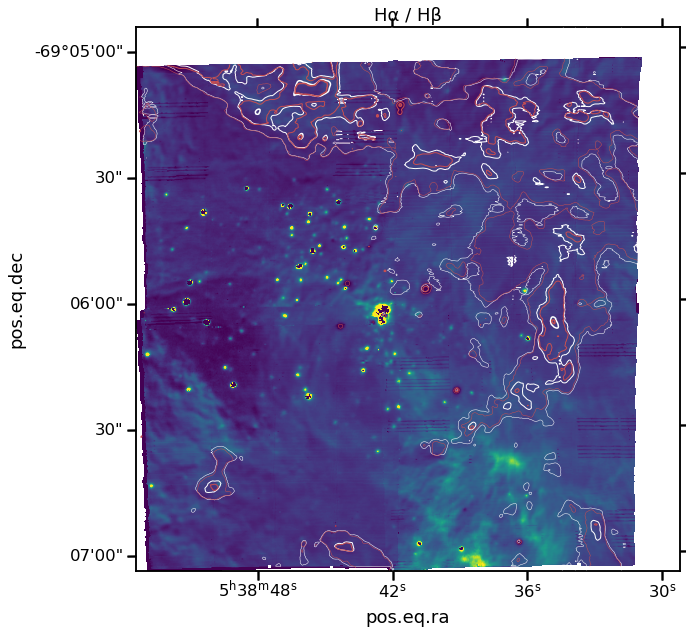

In [14]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw=dict(projection=WCS(mosaic_hdr)),
)
haflux = mosaic_ha_hdulist[1].data * mosaic_ha_hdulist[3].data
decrement = haflux / combo
ax.imshow(decrement, vmin=1.5, vmax=6.0)
ax.contour(
    haflux,
    levels=[2.5e5, 5e5, 10e5],
    linewidths=[0.5, 1.0, 1.5],
    colors="w",
)
ax.contour(2 * combo, levels=[2.5e5, 5e5, 10e5], linewidths=[0.5, 1.0, 1.5], colors="r")
ax.set_title("Hα / Hβ")

That looks a lot better.  Look at it again with emphasis on the lower extinction

Text(0.5, 1.0, 'Hα / Hβ')

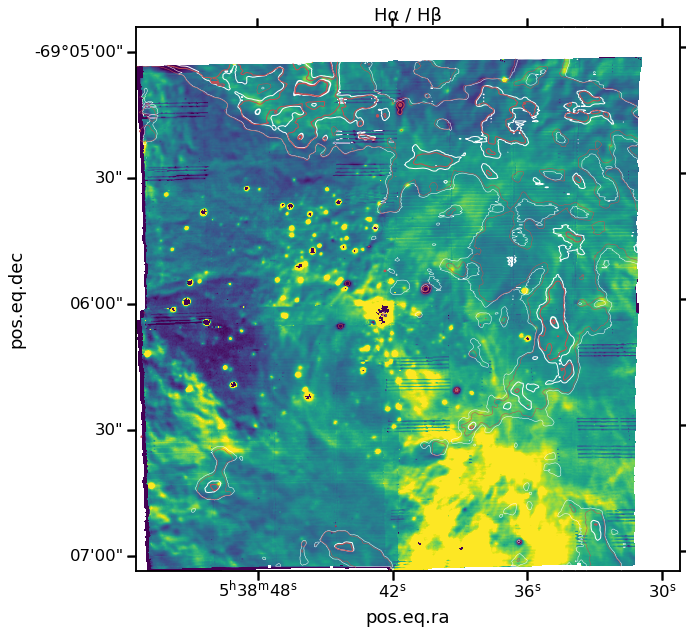

In [15]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw=dict(projection=WCS(mosaic_hdr)),
)
haflux = mosaic_ha_hdulist[1].data * mosaic_ha_hdulist[3].data
decrement = haflux / combo
ax.imshow(decrement, vmin=1.5, vmax=3.0)
ax.contour(
    haflux,
    levels=[2.5e5, 5e5, 10e5],
    linewidths=[0.5, 1.0, 1.5],
    colors="w",
)
ax.contour(2 * combo, levels=[2.5e5, 5e5, 10e5], linewidths=[0.5, 1.0, 1.5], colors="r")
ax.set_title("Hα / Hβ")

In the left-hand 2 fields, the alignment is not perfect.  We could maybe fix this by looking at the continuum images, but I will leave it for now.

## Now process all the emission lines and save them to files

In [80]:
afiles = sorted(Path("../data").glob("lmc-30dor-A-*bin01-*.fits"))

In [78]:
[_ for _ in afiles if "-sum" in str(_)]

[PosixPath('../data/lmc-30dor-A-CONT-8730-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-CONT-8749-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-CONT-9112-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-CONT-9145-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-ariii-5192-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-ariii-7136-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-ariii-7751-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-ariv-4711-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-ariv-4740-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-ariv-7171-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-ariv-7237-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-ariv-7263-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-c-ii-6151-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-ca-i-6104-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-cai-7890-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-cai-8125-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-cai-909

In [72]:
def update_p(a, b, check_mtime=False):
    """Return True iff path `a` exists but `b` does not
    
    Additionally, if `check_mtime` is true, then also update if `a` is newer than `b`
    """
    A = Path(a)
    B = Path(b)
    if A.exists():
        if B.exists():
            if check_mtime:
                return A.stat().st_mtime > B.stat().st_mtime
            else:
                return False
        else:
            return True
    else:
        return False

In [ ]:
for afile in afiles:
    pieces = []
    outfile = str(afile).replace("-A-", "-ABCD-")
    if not update_p(afile, outfile):
        continue
    print(f"{afile} -> {outfile}")
    for field in "ABCD":
        infile = str(afile).replace("-A-", f"-{field}-")
        hdu = fits.open(infile)["DATA"]
        del hdu.header["*3"]
        del hdu.header["CD3_*"]
        if field == "C":
            hdu.header["CRVAL1"] += Shift_1C.deg
            hdu.header["CRVAL2"] += Shift_2C.deg
        else:
            hdu.header["CRVAL1"] += Shift_1.deg
            hdu.header["CRVAL2"] += Shift_2.deg

        newdata, footprint = reproject.reproject_interp(
            hdu,
            mosaic_hdr,
        )
        pieces.append(newdata)
    combo = np.nanmedian(
        np.stack(pieces),
        axis=0,
    )
    fits.PrimaryHDU(header=mosaic_hdr, data=combo).writeto(outfile, overwrite=True)

### Same but for continuum files

In [ ]:
afiles = sorted(Path("../big-data").glob("lmc-30dor-A-subcube-*-cont.fits"))

In [ ]:
afiles

In [ ]:
for afile in afiles:
    pieces = []
    outfile = str(afile).replace(
        "-A-", "-ABCD-"
    ).replace(
        "/big-data/", "/data/"
    ).replace(
        "-subcube-", "-"
    ).replace(
        "-cont", "-avcont"
    )
    if not update_p(afile, outfile):
        continue
    print(f"{afile} -> {outfile}")
    for field in "ABCD":
        infile = str(afile).replace("-A-", f"-{field}-")
        ohdu = fits.open(infile)["DATA"]
        im = np.mean(ohdu.data, axis=0)
        m = (im < 0.0) | (im > 1e6)
        im[m] = np.nan
        hdu = fits.PrimaryHDU(
            data = im,
            header = WCS(ohdu.header).celestial.to_header(),
        )
        if field == "C":
            hdu.header["CRVAL1"] += Shift_1C.deg
            hdu.header["CRVAL2"] += Shift_2C.deg
        else:
            hdu.header["CRVAL1"] += Shift_1.deg
            hdu.header["CRVAL2"] += Shift_2.deg

        newdata, footprint = reproject.reproject_interp(
            hdu,
            mosaic_hdr,
        )
        pieces.append(newdata)
    combo = np.nanmedian(
        np.stack(pieces),
        axis=0,
    )
    fits.PrimaryHDU(header=mosaic_hdr, data=combo).writeto(outfile, overwrite=True)